<a href="https://www.kaggle.com/code/aryamanrao/dl-ecg-b-tech-project-mit-bih?scriptVersionId=164161617" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

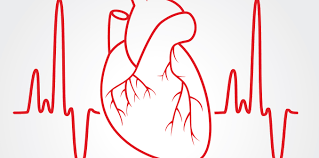


# **INTRODUCTION**

The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.
souces : https://physionet.org/content/mitdb/1.0.0/


Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**What is an ecg? **

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze. 

**Load Data**

In [2]:
!pip install wandb --upgrade --quiet

In [3]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient() 

personal_key_for_api = user_secrets.get_secret("wandb-key")

! wandb login $personal_key_for_api

2024-02-24 18:49:29.658251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 18:49:29.658384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 18:49:29.785178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv('/kaggle/input/mitbih_train.csv',header=None)
test_df = pd.read_csv('/kaggle/input/mitbih_test.csv',header=None)

print(train_df.shape)
print(test_df.shape)

train_df[187]=train_df[187].astype(int) #Labels
equilibre=train_df[187].value_counts(sort = False)
print(equilibre)

(87554, 188)
(21892, 188)
187
0    72471
1     2223
2     5788
3      641
4     6431
Name: count, dtype: int64


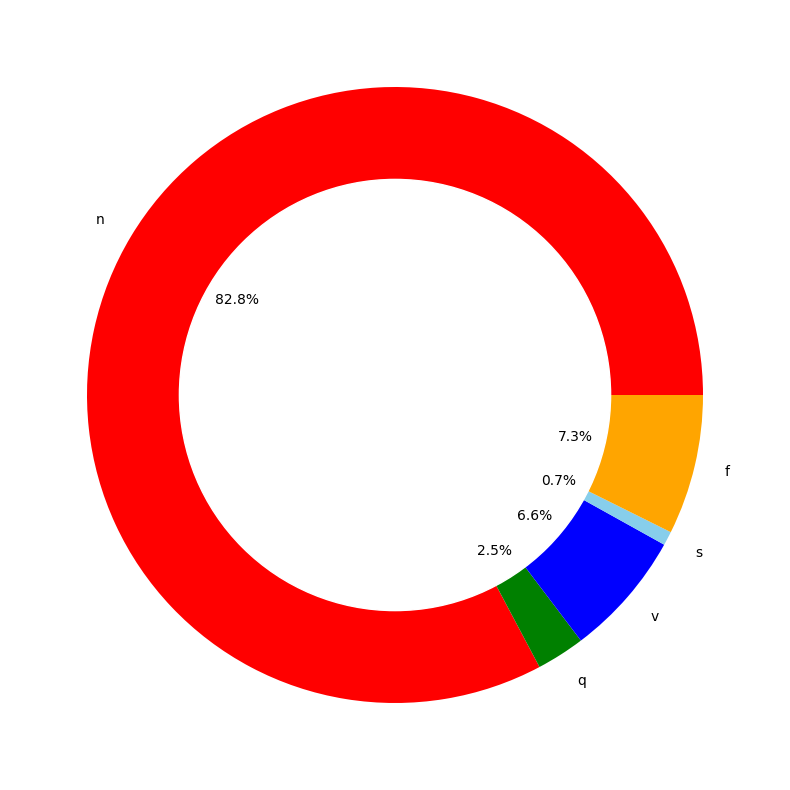

In [6]:
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [7]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=60000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

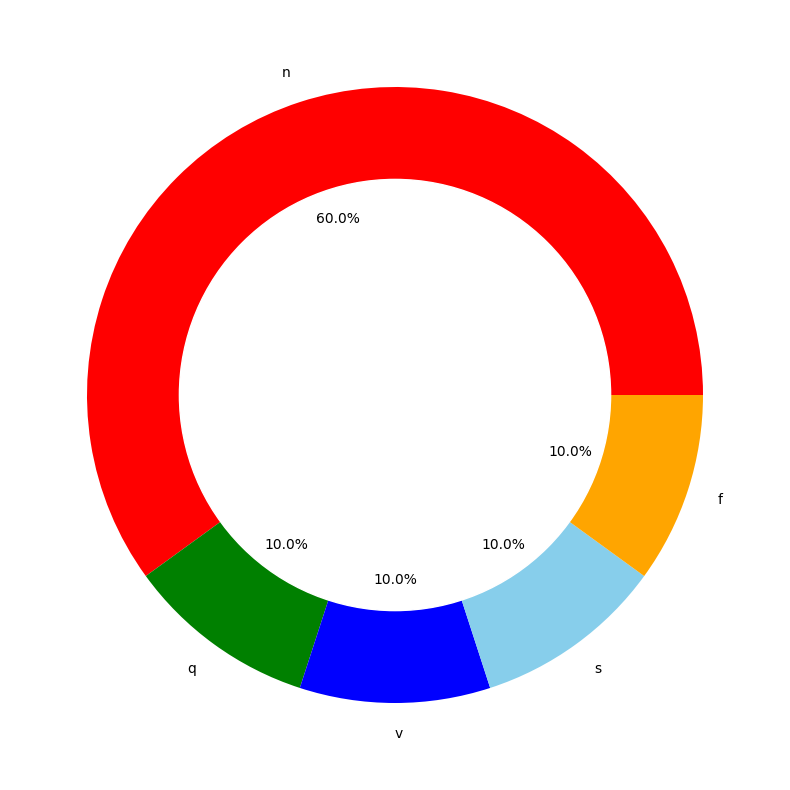

In [8]:
equilibre1=train_df[187].value_counts(sort = False)
#print(equilibre)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre1, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
# The sum of the weights of all examples stays the same.
weights = []
for i in range(5):
    weights.append((1 / equilibre[i]) * (100000.0 / 5.0))

class_weight = dict(zip(range(5), weights))
print(class_weight)

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

{0: 0.2759724579486967, 1: 8.99685110211426, 2: 3.455425017277125, 3: 31.201248049921997, 4: 3.1099362463069506}


In [10]:
target_train=train_df[187]
target_test=test_df[187]
y_train=target_train # to_categorical is one-hot encoding
y_test=target_test

X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

''' No Noise '''
# for i in range(len(X_train)):
#     X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [11]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(100000, 186, 1) (21892, 186, 1)
(100000,) (21892,)


In [12]:
sweep_configuration = {
    "method": "random",
    "name": "sweep",
    "metric": {"goal": "maximize", "name": "val_acc"},
    "parameters": {
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "epochs": {"values": [5, 10, 15, 20, 40]},
        "lr": {"max": 0.1, "min": 0.0001},
    },
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="my-first-sweep")

Create sweep with ID: h1ecutly
Sweep URL: https://wandb.ai/aryaman26601/my-first-sweep/sweeps/h1ecutly


In [13]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=len(X_test)).batch(batch_size)

In [14]:
''' Pytorch Implementation '''
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F

# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         self.conv1 = nn.Conv1d(1, 64, kernel_size = 6)
#         self.conv2 = nn.Conv1d(64, 64, kernel_size = 3)
#         self.conv3 = nn.Conv1d(64, 64, kernel_size = 3)
#         self.bn = nn.BatchNorm1d()
#         self.pool = nn.MaxPooling1d(3,2)#(kernel_size, stride)
#         self.fc1 = nn.Linear(64*3*3, 64)
#         self.fc2 = nn.linear(64, 32)
#         self.fc3 = nn.linear(32, 5)
        
#     def forward(self, x):
#         x = self.pool(self.bn(F.relu(self.conv1(x))))
#         x = self.pool(self.bn(F.relu(self.conv2(x))))
#         x = self.pool(self.bn(F.relu(self.conv3(x))))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

' Pytorch Implementation '

# Model Implementation

In [16]:
def make_model():
    im_shape = (X_train.shape[1], 1)
    inputs_cnn = Input(shape=im_shape, name='inputs_cnn')
    
    # First convolutional layer (186,1)
    conv1_1 = Convolution1D(256, 6, activation='relu')(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    pool1 = MaxPool1D(pool_size=3, strides=2, padding="same")(conv1_1)
    dropout1 = Dropout(0.05)(pool1)
    
    # Second convolution block (181,128)
    def convolution_block(pool_input, filters):
        conv1 = Convolution1D(filters, 5, activation='relu', 
                              kernel_regularizer=L2(0.1))(dropout1)
        lk1 = LeakyReLU(0.1)(conv1)
        bn1 = BatchNormalization()(lk1)
        conv2 = Convolution1D(filters, 5, activation='relu', padding='same', 
                              kernel_regularizer=L2(0.1))(bn1)
        lk2 = LeakyReLU(0.1)(conv2)
        bn2 = BatchNormalization()(lk2)
        #conv3 = Convolution1D(filters, 6, activation='relu', padding='same', kernel_regularizer=L2(0.1))(bn2)
        #bn3 = BatchNormalization()(conv3)
        return bn2
    
    conv21 = convolution_block(pool1, 64)
    conv22 = convolution_block(pool1, 128)
    conv23 = convolution_block(pool1, 64)
    
    attention = MultiHeadAttention(num_heads=6, key_dim=6)(conv21, conv22, conv23)
    pool = MaxPool1D(pool_size=2, strides=2, padding="same")(attention)
    dropout = Dropout(0.10)(pool)
    
    # Third convolutional layer
    conv3_1 = Convolution1D(64, 3, activation='relu')(dropout)
    conv3_1 = BatchNormalization()(conv3_1)
    pool3 = MaxPool1D(pool_size=2, strides=2, padding="same")(conv3_1)
    dropout3 = Dropout(0.05)(pool3)
    
    # Fourth convolutional layer
    conv4_1 = Convolution1D(32, 3, activation='relu')(dropout3)
    conv4_1 = BatchNormalization()(conv4_1)
    pool5 = MaxPool1D(pool_size=2, strides=2, padding="same")(conv4_1)
    pool5 = Dropout(0.10)(pool5) #
    
    avg_pool = AveragePooling1D(pool_size = 2, strides = 2, padding="same")(conv4_1)
    pool5_1 = Dropout(0.10)(avg_pool)
    ''' Alias '''
    #gavg_pool = GlobalAveragePooling1D()(dropout4)
    
    # Fifth convolutional layer
    #conv5_1 = Convolution1D(32, 3, activation='relu')(pool4)
    #conv5_1 = BatchNormalization()(conv5_1)
    #dropout5 = Dropout(0.10)(conv5_1)
    #pool5 = MaxPool1D(pool_size=2, strides=2, padding="same")(dropout5)
    
    # Attention mechanism
    #attention = Attention()([pool5, pool5])
    attention1 = MultiHeadAttention(num_heads=6, key_dim=6)(pool5, pool5_1, (pool5+pool5_1)/2)
    attention2 = MultiHeadAttention(num_heads=3, key_dim=3)(pool5, pool5, pool5)
    
    summed_attention = tf.keras.layers.add([attention1, attention2])
    normalized_attention = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(summed_attention)
    # Flatten and dense layers
    flatten = Flatten()(normalized_attention)
    #gavg_pool = GlobalAveragePooling1D()(normalized_attention)
    dense_end1 = Dense(64)(flatten)
    lr1 = LeakyReLU(0.1)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(lr1)
    lr2 = LeakyReLU(0.1)(dense_end2)
    
    # Output layer
    main_output = Dense(5, activation='softmax', name='main_output')(lr2)

    model = Model(inputs= inputs_cnn, outputs=main_output)
    print(model.summary())
    return model

In [ ]:
 ''' Tensorflow Implementation using a custom training loop '''
# def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
#     with tf.GradientTape() as tape:
#         logits = model(x, training = True)  # logits attached
#         loss_value = loss_fn(y, logits) # loss calculated
        
#     grads = tape.gradient(loss_value, model.trainable_weights) # gradients calculated
#     optimizer.apply_gradients(zip(grads, model.trainable_weights)) #optimizer calculated

#     train_acc_metric.update_state(y, logits)
#     return loss_value

    
# def test_step(x, y, model, loss_fn, val_acc_metric):
#     val_logits = model(x, training=False)
#     loss_value = loss_fn(y, val_logits)
#     val_acc_metric.update_state(y, val_logits)
#     return loss_value

In [ ]:
# def train(train_dataset, val_dataset, model, optimizer,
#           loss_fn, train_acc_metric, val_acc_metric, epochs=40, 
#           log_step=200, val_log_step=50):
  
#     for epoch in range(epochs):
#         print("\nStart of epoch %d" % (epoch,))

#         train_loss, val_loss = [], []

#         # Iterate over the batches of the dataset
#         for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
#             loss_value = train_step(x_batch_train, y_batch_train, 
#                                     model, optimizer, 
#                                     loss_fn, train_acc_metric)
#             train_loss.append(float(loss_value))

#         # Run a validation loop at the end of each epoch
#         for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
#             val_loss_value = test_step(x_batch_val, y_batch_val, 
#                                        model, loss_fn, 
#                                        val_acc_metric)
#             val_loss.append(float(val_loss_value))
            
#         # Display metrics at the end of each epoch
#         train_acc = train_acc_metric.result()
#         print("Training acc over epoch: %.4f" % (float(train_acc),))

#         val_acc = val_acc_metric.result()
#         print("Validation acc: %.4f" % (float(val_acc),))

#         # Reset metrics at the end of each epoch
#         train_acc_metric.reset_states()
#         val_acc_metric.reset_states()

#         #3️⃣ log metrics using wandb.log
#         wandb.log({'epochs': epoch,
#                    'loss': np.mean(train_loss),
#                    'accuracy': float(train_acc), 
#                    'val_loss': np.mean(val_loss),
#                    'val_accuracy':float(val_acc)})

In [17]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
# from keras.callbacks import Callback
# class LogBestAccuracy(Callback):
#     def __init__(self, run):
#         super(LogBestAccuracy, self).__init__()
#         self.run = run
#         self.best_accuracy = -float('inf')

#     def on_epoch_end(self, epoch, logs=None):
#         val_accuracy = logs.get('val_accuracy')
#         if val_accuracy is not None and val_accuracy > self.best_accuracy:
#             self.best_accuracy = val_accuracy
#             wandb.log({'best_accuracy': self.best_accuracy})

In [18]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Attention, MultiHeadAttention, Lambda, LeakyReLU
from keras.layers import Input, AveragePooling1D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.regularizers import L2
import keras
import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [36]:
def train():
    version = 44
    config = {"learning_rate": 0.001, "epochs": 20,
        "batch_size": 128, "log_step": 200,
        "val_log_step": 50, "architecture": "CNN-Attention", "dataset": "MIT-BIH"}

    run = wandb.init(project='my-first-project', name=f"Model v{version}", config=config)
    config = wandb.config

    # Initialize model.
    model = make_model()
    optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    model.compile(optimizer, loss_fn ,metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, 
                               patience=18, verbose=0, mode='auto', baseline=None),
             ModelCheckpoint(filepath=f"/kaggle/working/best_model_{version}.h5", 
                             monitor='val_loss', save_best_only=True), 
                WandbCallback()]

    history = model.fit(X_train, y_train,epochs=config.epochs,
                      callbacks=callbacks, batch_size=config.batch_size,
                      validation_data=(X_test,y_test))

    run.finish()

train()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_cnn (InputLayer)     [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 181, 256)             1792      ['inputs_cnn[0][0]']          
                                                                                                  
 batch_normalization_9 (Bat  (None, 181, 256)             1024      ['conv1d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d_4 (MaxPoolin  (None, 91, 256)              0         ['batch_normalization_9[

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_194141-2f3kkx6h/files/model-best)... Done. 0.0s


782/782 [==============================] - 41s 40ms/step - loss: 2.2470 - accuracy: 0.8547 - val_loss: 0.5471 - val_accuracy: 0.9034


accuracy,▁
epoch,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.85465
best_epoch,0
best_val_loss,0.54708
epoch,0
loss,2.24699
val_accuracy,0.90339


In [ ]:
wandb.agent(sweep_id, function = train, count = 5)

wandb: Agent Starting Run: dq8flxr3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	lr: 0.08682988249934366
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_cnn (InputLayer)     [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 181, 256)             1792      ['inputs_cnn[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 181, 256)             1024      ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 91, 256)              0         ['batch_normalization[0][0

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_194450-dq8flxr3/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 69s 19ms/step - loss: 1.1082 - accuracy: 0.8435 - val_loss: 0.7203 - val_accuracy: 0.8182
Epoch 2/20
3125/3125 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8998

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_194450-dq8flxr3/files/model-best)... Done. 0.0s


3125/3125 [==============================] - 59s 19ms/step - loss: 0.4159 - accuracy: 0.8998 - val_loss: 0.3722 - val_accuracy: 0.9218
Epoch 3/20
2366/3125 [=====================>........] - ETA: 11s - loss: 0.3290 - accuracy: 0.9144

In [19]:
# Initialize WandB with your project name and optionally with configurations.
# lay around with the config values and see the result on your WandB dashboard.

''' CHANGE THE VERSION NUMBER, THANK YOU '''
version = 43

run = wandb.init(project='my-first-project', name=f"Model v{version}", config=config)
config = wandb.config

# Initialize model.
model = make_model()
optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits = True)
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

wandb: Currently logged in as: aryaman26601. Use `wandb login --relogin` to force relogin


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs_cnn (InputLayer)     [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 181, 256)             1792      ['inputs_cnn[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 181, 256)             1024      ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 91, 256)              0         ['batch_normalization[0][0

In [20]:
model.compile(optimizer, loss_fn ,metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, 
                           patience=18, verbose=0, mode='auto', baseline=None),
         ModelCheckpoint(filepath=f"/kaggle/working/best_model_{version}.h5", 
                         monitor='val_loss', save_best_only=True), 
            WandbCallback()]

history = model.fit(X_train, y_train,epochs=config.epochs,
                  callbacks=callbacks, batch_size=config.batch_size,
                  validation_data=(X_test,y_test))

model.load_weights(f'/kaggle/working/best_model_{version}.h5')

run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100


I0000 00:00:1708800690.028692     146 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - ETA: 0s - loss: 2.2370 - accuracy: 0.8623

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 50s 42ms/step - loss: 2.2370 - accuracy: 0.8623 - val_loss: 1.2911 - val_accuracy: 0.3953
Epoch 2/100
781/782 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.9068

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.4181 - accuracy: 0.9068 - val_loss: 0.3095 - val_accuracy: 0.9409
Epoch 3/100
781/782 [============================>.] - ETA: 0s - loss: 0.3323 - accuracy: 0.9163

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 31s 39ms/step - loss: 0.3323 - accuracy: 0.9164 - val_loss: 0.3039 - val_accuracy: 0.9360
Epoch 4/100
782/782 [==============================] - 23s 29ms/step - loss: 0.2882 - accuracy: 0.9236 - val_loss: 0.7029 - val_accuracy: 0.7179
Epoch 5/100
781/782 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.9289

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.2616 - accuracy: 0.9289 - val_loss: 0.2832 - val_accuracy: 0.9252
Epoch 6/100
781/782 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9327

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.2453 - accuracy: 0.9327 - val_loss: 0.2568 - val_accuracy: 0.9428
Epoch 7/100
782/782 [==============================] - 22s 29ms/step - loss: 0.2335 - accuracy: 0.9350 - val_loss: 0.2619 - val_accuracy: 0.9223
Epoch 8/100
782/782 [==============================] - 23s 29ms/step - loss: 0.2260 - accuracy: 0.9369 - val_loss: 0.2585 - val_accuracy: 0.9237
Epoch 9/100
781/782 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9401

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 38ms/step - loss: 0.2139 - accuracy: 0.9401 - val_loss: 0.1805 - val_accuracy: 0.9563
Epoch 10/100
782/782 [==============================] - 23s 29ms/step - loss: 0.2108 - accuracy: 0.9411 - val_loss: 0.3923 - val_accuracy: 0.8610
Epoch 11/100
782/782 [==============================] - 22s 29ms/step - loss: 0.2047 - accuracy: 0.9420 - val_loss: 0.4408 - val_accuracy: 0.8399
Epoch 12/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1998 - accuracy: 0.9436 - val_loss: 0.2212 - val_accuracy: 0.9417
Epoch 13/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1980 - accuracy: 0.9446 - val_loss: 0.2230 - val_accuracy: 0.9361
Epoch 14/100
781/782 [============================>.] - ETA: 0s - loss: 0.1935 - accuracy: 0.9458

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 32s 40ms/step - loss: 0.1935 - accuracy: 0.9458 - val_loss: 0.1577 - val_accuracy: 0.9645
Epoch 15/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1948 - accuracy: 0.9440 - val_loss: 0.2231 - val_accuracy: 0.9415
Epoch 16/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1871 - accuracy: 0.9467 - val_loss: 0.1994 - val_accuracy: 0.9459
Epoch 17/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1844 - accuracy: 0.9477 - val_loss: 0.7549 - val_accuracy: 0.7915
Epoch 18/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1838 - accuracy: 0.9480 - val_loss: 0.3629 - val_accuracy: 0.8887
Epoch 19/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1839 - accuracy: 0.9477 - val_loss: 0.2717 - val_accuracy: 0.9287
Epoch 20/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1813 - accuracy: 0.9490 - val_loss: 0.3517 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.1613 - accuracy: 0.9546 - val_loss: 0.1538 - val_accuracy: 0.9617
Epoch 31/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1621 - accuracy: 0.9546 - val_loss: 0.2255 - val_accuracy: 0.9402
Epoch 32/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1579 - accuracy: 0.9553 - val_loss: 0.1787 - val_accuracy: 0.9575
Epoch 33/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1605 - accuracy: 0.9554 - val_loss: 0.3963 - val_accuracy: 0.8730
Epoch 34/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1581 - accuracy: 0.9563 - val_loss: 0.2698 - val_accuracy: 0.9182
Epoch 35/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1588 - accuracy: 0.9555 - val_loss: 0.3243 - val_accuracy: 0.9084
Epoch 36/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1583 - accuracy: 0.9562 - val_loss: 0.2909 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.1509 - accuracy: 0.9584 - val_loss: 0.1394 - val_accuracy: 0.9672
Epoch 42/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1509 - accuracy: 0.9576 - val_loss: 0.1459 - val_accuracy: 0.9674
Epoch 43/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1504 - accuracy: 0.9588 - val_loss: 0.1893 - val_accuracy: 0.9481
Epoch 44/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1463 - accuracy: 0.9585 - val_loss: 0.1504 - val_accuracy: 0.9597
Epoch 45/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1491 - accuracy: 0.9578 - val_loss: 0.2323 - val_accuracy: 0.9428
Epoch 46/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1489 - accuracy: 0.9588 - val_loss: 0.2795 - val_accuracy: 0.9204
Epoch 47/100
781/782 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9586

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.1470 - accuracy: 0.9586 - val_loss: 0.1327 - val_accuracy: 0.9706
Epoch 48/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1445 - accuracy: 0.9598 - val_loss: 0.2626 - val_accuracy: 0.9113
Epoch 49/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1426 - accuracy: 0.9600 - val_loss: 0.3017 - val_accuracy: 0.9032
Epoch 50/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1445 - accuracy: 0.9599 - val_loss: 0.2566 - val_accuracy: 0.9314
Epoch 51/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1445 - accuracy: 0.9606 - val_loss: 0.2417 - val_accuracy: 0.9403
Epoch 52/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1414 - accuracy: 0.9606 - val_loss: 0.1684 - val_accuracy: 0.9566
Epoch 53/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1419 - accuracy: 0.9612 - val_loss: 0.1689 - val_accuracy

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240224_185026-jzfyo9ha/files/model-best)... Done. 0.0s


782/782 [==============================] - 30s 39ms/step - loss: 0.1378 - accuracy: 0.9625 - val_loss: 0.1199 - val_accuracy: 0.9741
Epoch 63/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1357 - accuracy: 0.9629 - val_loss: 0.1643 - val_accuracy: 0.9550
Epoch 64/100
782/782 [==============================] - 23s 29ms/step - loss: 0.1337 - accuracy: 0.9628 - val_loss: 0.1518 - val_accuracy: 0.9630
Epoch 65/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1380 - accuracy: 0.9617 - val_loss: 0.2269 - val_accuracy: 0.9414
Epoch 66/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1371 - accuracy: 0.9624 - val_loss: 0.3053 - val_accuracy: 0.8905
Epoch 67/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1331 - accuracy: 0.9639 - val_loss: 0.1316 - val_accuracy: 0.9692
Epoch 68/100
782/782 [==============================] - 22s 29ms/step - loss: 0.1378 - accuracy: 0.9626 - val_loss: 0.1612 - val_accuracy

accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁█▇▇█▆██▆▇█▇▇███▇▇▇▇████▇███▇█████▇▇███▇
val_loss,█▂▂▂▁▃▂▂▅▂▁▂▂▁▁▂▃▂▂▂▁▁▂▁▂▂▁▁▂▂▁▁▂▁▂▂▁▁▁▂
accuracy,0.96506
best_epoch,61
best_val_loss,0.11994
epoch,79
loss,0.1286
val_accuracy,0.87799


Accuracy: 97.41%


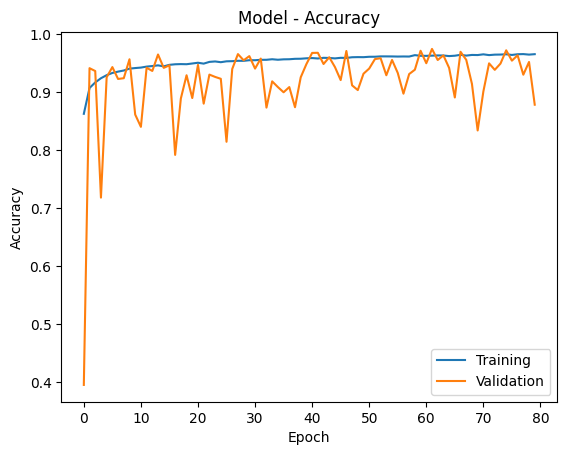

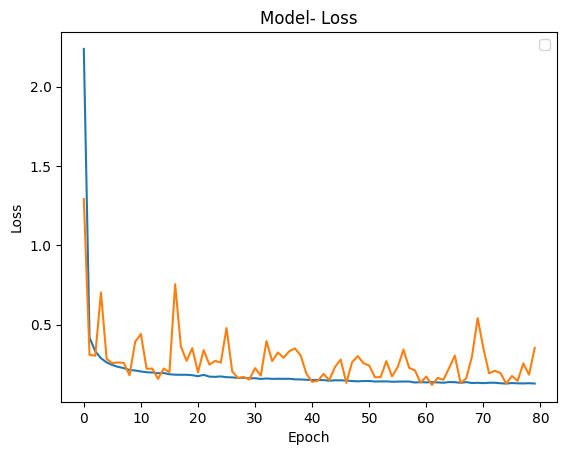

685/685 [==============================] - 2s 3ms/step


In [21]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

i take the next function from : https://www.kaggle.com/coni57/model-from-arxiv-1805-00794

Normalized confusion matrix

Confusion matrix, without normalization


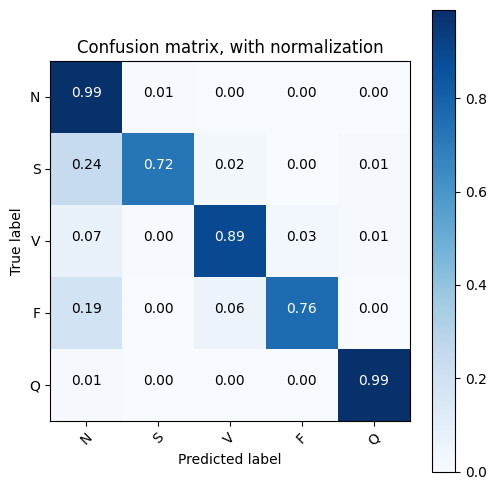

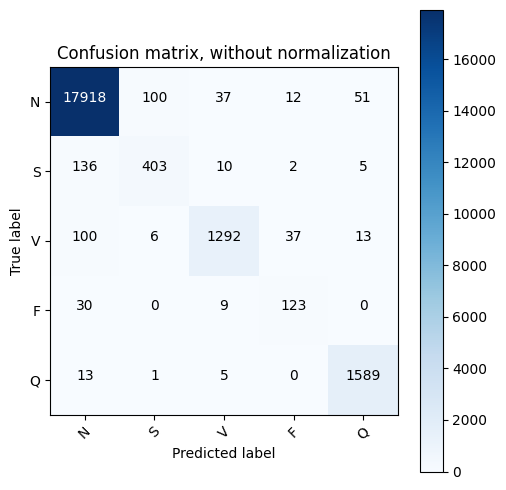

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
print()
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=False,
                      title='Confusion matrix, without normalization')
plt.show()



We underlign that two class(supraventricular and fusion) is weeker than the other. maybe due to less exemple in the starter dataset. I will try to improve in the next version.

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.79      0.72      0.76       556
         2.0       0.95      0.89      0.92      1448
         3.0       0.71      0.76      0.73       162
         4.0       0.96      0.99      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.88      0.87      0.87     21892
weighted avg       0.97      0.97      0.97     21892



In [26]:
y_pred[0]

array([1.00e+00, 1.79e-05, 8.98e-07, 8.21e-10, 1.94e-06], dtype=float32)

In [27]:
from sklearn.preprocessing import label_binarize
y_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

In [28]:
y_binary

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [30]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# ROC Curve for Multi-classification

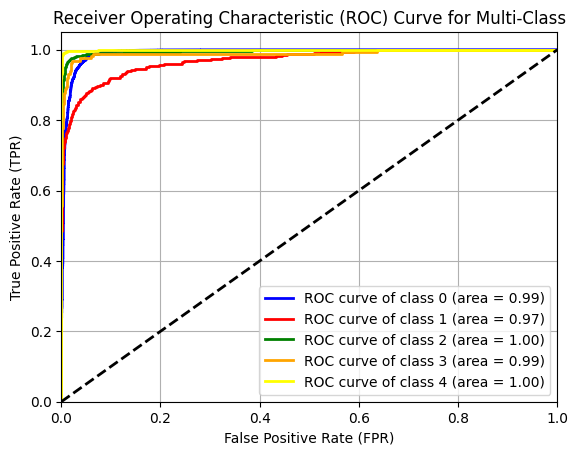

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ROC AUC Curve

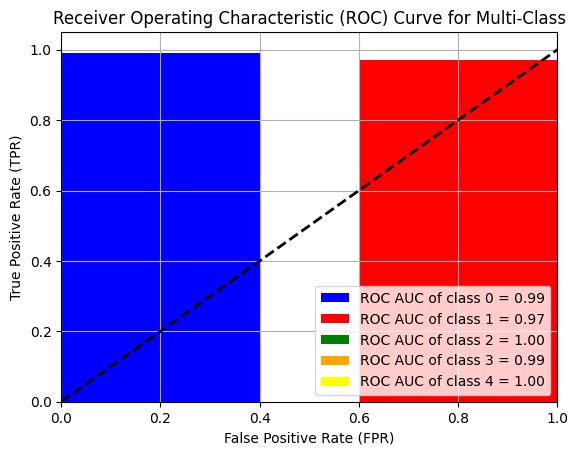

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'yellow'])
for i, color in zip(range(5), colors):
    plt.bar(i, roc_auc[i], color=color, label='ROC AUC of class {0} = {1:0.2f}'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()